In [2]:
# Python packages to manipulate files
import os
import pathlib
from pathlib import Path
import datetime
# Tensorflow and Numpy packages
import tensorflow as tf
import numpy as np

# Display related packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import PIL
import PIL.Image

%matplotlib inline


### Check available compute capabilities
If you have a GPU uncomment the last line to check that your Tensorflow installation supports GPU

In [3]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
# #tf.config.set_visible_devices([], 'GPU')

Uncomment these lines if you want to uncompress the image dataset.

In [4]:
# [ ! -d ./data ] && tar xvzf ./arabic_handwritten_data.tgz || echo "Dataset folder already exists"

### Dive into the data
We open a random file from the dataset and display it.

You can see that it contains a handwritten arabic letter. 

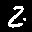

In [5]:
Image(filename = "data/test_data/id_10_label_5.png", width = 32, height = 32)

### A look at the folder content
We list the files inside each folder and we can see that we have thousands of png files that have a similar naming pattern.
We can guess the letter to which the image belongs through the file name. 
We pick a random set of files and display their names.

In [6]:
directory = "./data/train_data/"
images = os.listdir(directory)

In [7]:
images[0:12]

['id_2207_label_24.png',
 'id_3835_label_4.png',
 'id_11339_label_18.png',
 'id_13198_label_26.png',
 'id_3256_label_15.png',
 'id_40_label_5.png',
 'id_4101_label_9.png',
 'id_7121_label_23.png',
 'id_4808_label_13.png',
 'id_3739_label_20.png',
 'id_10171_label_12.png',
 'id_154_label_20.png']

### Displaying the data
We pick 12 images and display them in a grid using matplotlib.

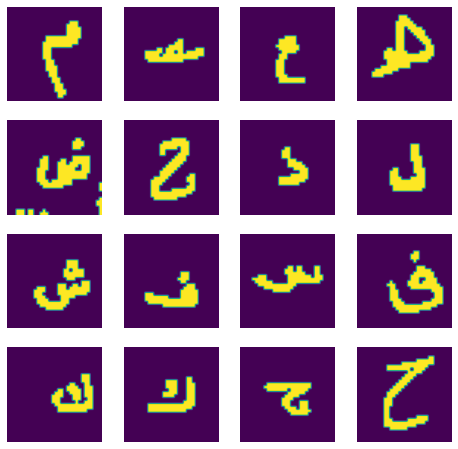

In [8]:
ncols = 4
nrows = 4

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

for i, img_path in enumerate(images[0:ncols*nrows]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Disable axes display

    img = mpimg.imread(directory+img_path)
    plt.imshow(img)

plt.show()

### Define the data dictionary
To identify the model predictions easilly, we create a list identifing each label. The list contains the real name of the letter instead of just its index in the alphabet order. We provide two versions of this list:
 * the first one shows letters written in latin with phonetic representation.
 * the second one shows the letters in arabic.

For more details about arabic alphabet go to this [Wikipedia page](https://en.wikipedia.org/wiki/Arabic_alphabet). 
 
Our dataset is organized using the **Common hijāʾī order**.

In [9]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

In [10]:
arabic_char_utf8 = ("أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي")

In [11]:
len(arabic_characters)

28

In [12]:
arabic_characters[12]

'sheen'

In [13]:
arabic_char_utf8[12]

'ش'

### Tensorboard and Monitoring

We create a folder to store tensorflow logs and display them in Tensorboard.

Tensorboard is a tool that allows you to track model metrics. 

Jupyter and Google colab allows you to display Tensorboard inside the notebook through an extension.

In [14]:
logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [15]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir $logdir

### Load the data

We process the folder and load each files in it.

We extract the label of each picture and convert the image to a rescaled matrix of 32x32x3.

In [17]:
batch_size = 32
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        label = tf.strings.regex_replace(input=file_path,pattern=r".+_label_(\d+)\.png", rewrite=r"\1")
        label = tf.strings.to_number(label, tf.int32)-1
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):

        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [str(path.absolute()) for path in Path(data_dir).glob("*.png")]
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x)))
    return files_ds

In [18]:
train_dataset_path = "data/train_data"
test_dataset_path = "data/test_data"

train_ds = get_dataset(train_dataset_path).shuffle(buffer_size=batch_size*10).batch(batch_size)
valid_ds = get_dataset(test_dataset_path).batch(batch_size)

### Define the neural network structure


In [19]:
model = tf.keras.Sequential([
    # Convert the 32x32x3 image into a flat vector of 32x32x3 = 3072 values
    tf.keras.layers.Flatten(input_shape=(32, 32, 3), name='flatten_input'),
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 28 neurons
    tf.keras.layers.Dense(28, name='hidden_to_logits'),
])

### Display the model details

In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (Flatten)      (None, 3072)              0         
_________________________________________________________________
input_to_hidden1 (Dense)     (None, 256)               786688    
_________________________________________________________________
hidden1_to_hidden2 (Dense)   (None, 128)               32896     
_________________________________________________________________
hidden_to_logits (Dense)     (None, 28)                3612      
Total params: 823,196
Trainable params: 823,196
Non-trainable params: 0
_________________________________________________________________


### Define the optimizer and the loss
In this example, we use **SparseCategoricalCrossentropy** because the label is defined as a number.

If we use a one hot vector instead, we should use **CategoricalCrossentropy**.


In [21]:
optimizer = tf.keras.optimizers.Adam(lr=1E-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [22]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [23]:
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

### Prepare the training loop
We define a train_step function that would update the newtork weights each time it is called.

We also define a similar function to track the performance of the model on the validation set.

In [24]:
num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [27]:
# Defined a function to train the model using tf.GradientTape
@tf.function
def train_step(image, label):
  # Initialise a GradientTape to track the operations
  with tf.GradientTape() as tape:
    # Compute the logits (un-normalised scores) of the current batch of examples
    # using the neural network architecture we defined earlier
    logits = model(image)
    loss = loss_object(label, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  # Add current batch loss to our loss metric tracker - note the function call semantics
  train_loss(loss)
  train_accuracy(label, logits)

In [28]:
@tf.function
def valid_step(image, label):
    valid_logits = model(image, training=False)
    valid_accuracy(label, valid_logits)
    loss = loss_object(label, valid_logits)
    valid_loss(loss)

### Create folders to collect statistics for Tensorboard

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
valid_log_dir = 'logs/gradient_tape/' + current_time + '/valid'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
valid_summary_writer = tf.summary.create_file_writer(valid_log_dir)

### Run the training loop

In [ ]:
for epoch in range(num_epochs):
  # Loop over our data pipeline
  for image, label in train_ds:
    train_step(image, label)

  for image, label in valid_ds:
    valid_step(image, label)

  # Code specific to Tensorflow 
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  with valid_summary_writer.as_default():
    tf.summary.scalar('loss', valid_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', valid_accuracy.result(), step=epoch)

  template = 'Epoch {:03d}, Train Loss: {:.3f}, Train Accuracy: {:.3%}, Valid Loss: {:.3f}, Valid Accuracy: {:.3%}'
  print(template.format(epoch+1,
                        train_loss.result(), 
                        train_accuracy.result(),
                        valid_loss.result(),
                        valid_accuracy.result(),
                       ))
  
  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())
  valid_losses.append(valid_loss.result())
  valid_accuracies.append(valid_accuracy.result())

### Plot the loss and the accuracy 

In [ ]:
# Plot the loss for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), valid_losses)
plt.title('Loss vs epochs')

# Plot the accuracy for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_accuracies)
plt.plot(range(num_epochs), valid_accuracies)
plt.title('Accuracy vs epochs')

### Display predictions

In [ ]:
images, labels = next(iter(valid_ds))
_logits = model(images, training=False)
predicted_labels = tf.argmax(_logits, axis=1, output_type=tf.int32)
img_indexs = np.arange(images.numpy().shape[0])
np.random.shuffle(img_indexs)

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)

    img_index = img_indexs[i]
    predicted_label = int(predicted_labels[img_index])

    plt.imshow(images[img_index])

    actual_label = int(labels[img_index].numpy())
    plt.xlabel("\n Actual: ({})\n Predicted: ({})".format(
        arabic_char_utf8[actual_label-1],  arabic_char_utf8[predicted_label-1]
    ))

plt.tight_layout()
plt.show()
